<a href="https://colab.research.google.com/github/ArpitKadam/Attention-Is-All-You-Code/blob/main/LLM-from-Scratch/CHP_12_Temperature_Scaling_and_Top_K_Sampling_in_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREVIOUSLY**

In [4]:
with open("/content/the-verdict.txt", "r") as file:
  text_data = file.read()

import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

class GPTDataSetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    for i in range(0, len(token_ids) - max_length, stride):
      ## Here max_length is the context_size
      input_chunk = token_ids[i: i + max_length]
      target_chunk = token_ids[i+1: i + max_length + 1]

      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, index):
    return self.input_ids[index], self.target_ids[index]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPTDataSetV1(txt, tokenizer, max_length, stride)

  dataloader = DataLoader(
      dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers
  )

  return dataloader

train_ratio = 0.80
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=256, stride=256)
val_loader = create_dataloader_v1(val_data, batch_size=2, max_length=256, stride=256)

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, drop_rate, num_heads, qkv_bias):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(drop_rate)
    self.register_buffer("simple_mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    batch, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = torch.matmul(queries, keys.transpose(2, 3))

    attn_scores.masked_fill_(
        self.simple_mask.bool()[:num_tokens, :num_tokens],
        -torch.inf
    )

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, values)

    context_vec = context_vec.transpose(1, 2)

    context_vec = context_vec.contiguous().view(batch, num_tokens, self.d_out)

    context_vec = self.out_proj(context_vec)

    return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        qkv_bias = cfg['qkv_bias'],
        drop_rate = cfg['drop_rate']
      )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    ## Connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    ## Conection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

class GPT_MODEL(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_out = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
    batch_size, seq_length = x.shape

    token_embeddings = self.token_emb(x)
    pos_embeddings = self.pos_emb(torch.arange(seq_length, device=x.device))

    x = token_embeddings + pos_embeddings
    x = self.drop_out(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):

    idx_crop = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_crop)

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  token_list = token_ids.squeeze(0).tolist()
  decoded_text = tokenizer.decode(token_list)
  return decoded_text

def cal_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    ## Reduce the number of batches to match the total number of batches in dataloader
    ## i.e if num_batches exceeds the number of the batches in data_loader
    num_batches = min(num_batches, len(data_loader))

  for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
    if batch_idx < num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

In [5]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = cal_loss_loader(train_loader, model, device, eval_iter)
    val_loss = cal_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model, encoded, 50, context_size)
  decoded = token_ids_to_text(token_ids, tokenizer)
  print(decoded.replace("\n", " "))
  model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

  ## Initialize list to track losses and tokens seen
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  ## Main Training Loop
  for epoch in range(num_epochs):
    model.train()     ## set model to training mode

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()    ## Resests loss gradients from from previous batch iteration
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      loss.backward()     ## Calculate loss gradients
      optimizer.step()    ## Calculate model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step += 1

      ## Optional Evaluation Step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch: {epoch+1}, Step: {global_step:06d} Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    generate_and_print_sample(model, tokenizer, device, start_context)

  return train_losses, val_losses, track_tokens_seen

In [6]:
import time
start_time = time.time()

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT_MODEL(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=2, eval_iter=2,
    start_context="I glanced after him", tokenizer=tokenizer
)

end_time = time.time()
total_time_in_min = (end_time - start_time) / 60
print(f"Total Training Time: {total_time_in_min:.2f} minutes")

Epoch: 1, Step: 000000 Train Loss: 9.657, Val Loss: 10.079
Epoch: 1, Step: 000002 Train Loss: 8.805, Val Loss: 9.177
Epoch: 1, Step: 000004 Train Loss: 8.354, Val Loss: 8.625
Epoch: 1, Step: 000006 Train Loss: 7.677, Val Loss: 8.086
I glanced after him,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch: 2, Step: 000008 Train Loss: 7.131, Val Loss: 7.585
Epoch: 2, Step: 000010 Train Loss: 6.601, Val Loss: 7.214
Epoch: 2, Step: 000012 Train Loss: 6.282, Val Loss: 6.987
Epoch: 2, Step: 000014 Train Loss: 6.057, Val Loss: 6.867
I glanced after him, the,,,,,,,, the,,,,,,,, the,, the,,,,,, the,,,,,,,,,,, the,, the,,,,,
Epoch: 3, Step: 000016 Train Loss: 6.026, Val Loss: 6.834
Epoch: 3, Step: 000018 Train Loss: 10.231, Val Loss: 12.554
Epoch: 3, Step: 000020 Train Loss: 5.699, Val Loss: 6.857
Epoch: 3, Step: 000022 Train Loss: 5.692, Val Loss: 6.865
I glanced after him, the of the of the of the of the of the of the.                                   
Epoch: 4, Step: 000024 Train Loss: 5.

# **STRATEGY-1: TEMPERATURE SCALING**

In [8]:
model.to("cpu")
model.eval()

GPT_MODEL(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_fea

In [9]:
toke_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every movement moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output:")
print(token_ids_to_text(toke_ids, tokenizer))

Output:
Every movement moves you know," was not that my hostess was "interesting": on that point I could have given Miss Croft the fullest reass


In [10]:
vocab = {
    "closer":0,
    "effort":1,
    "every":2,
    "forward":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "towards":7,
    "you":8
}

reverse_vocab = {k:v for v, k in vocab.items()}

In [15]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
print(probas)

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])


In [16]:
next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(reverse_vocab[next_token_id])

3
forward


**To implement a probabilistic sampling process, we can now replace the argmax with the multonomial function in PyTorch**

In [17]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(next_token_id)
print(reverse_vocab[next_token_id])

3
forward


In [18]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {reverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x effort
0 x every
582 x forward
2 x inches
0 x moves
0 x pizza
343 x towards


<div class="alert alert-block alert-success">

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

</div>

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

In [19]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

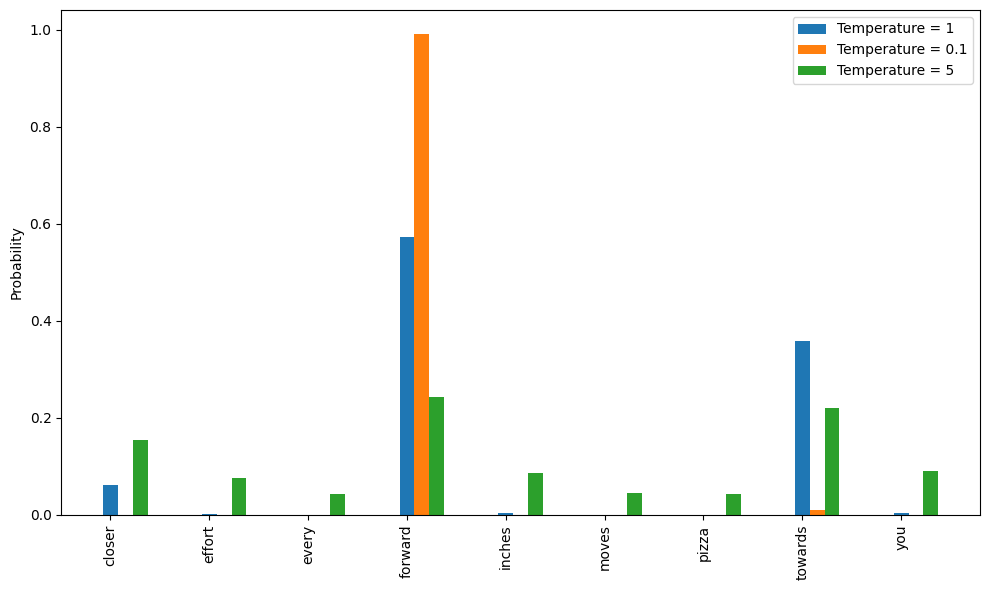

In [22]:
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores.

In other words, using a temperature of 1 is the same as not
using any temperature scaling.

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often.

This can add more variety to the
generated texts but also more often results in nonsensical text.

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>

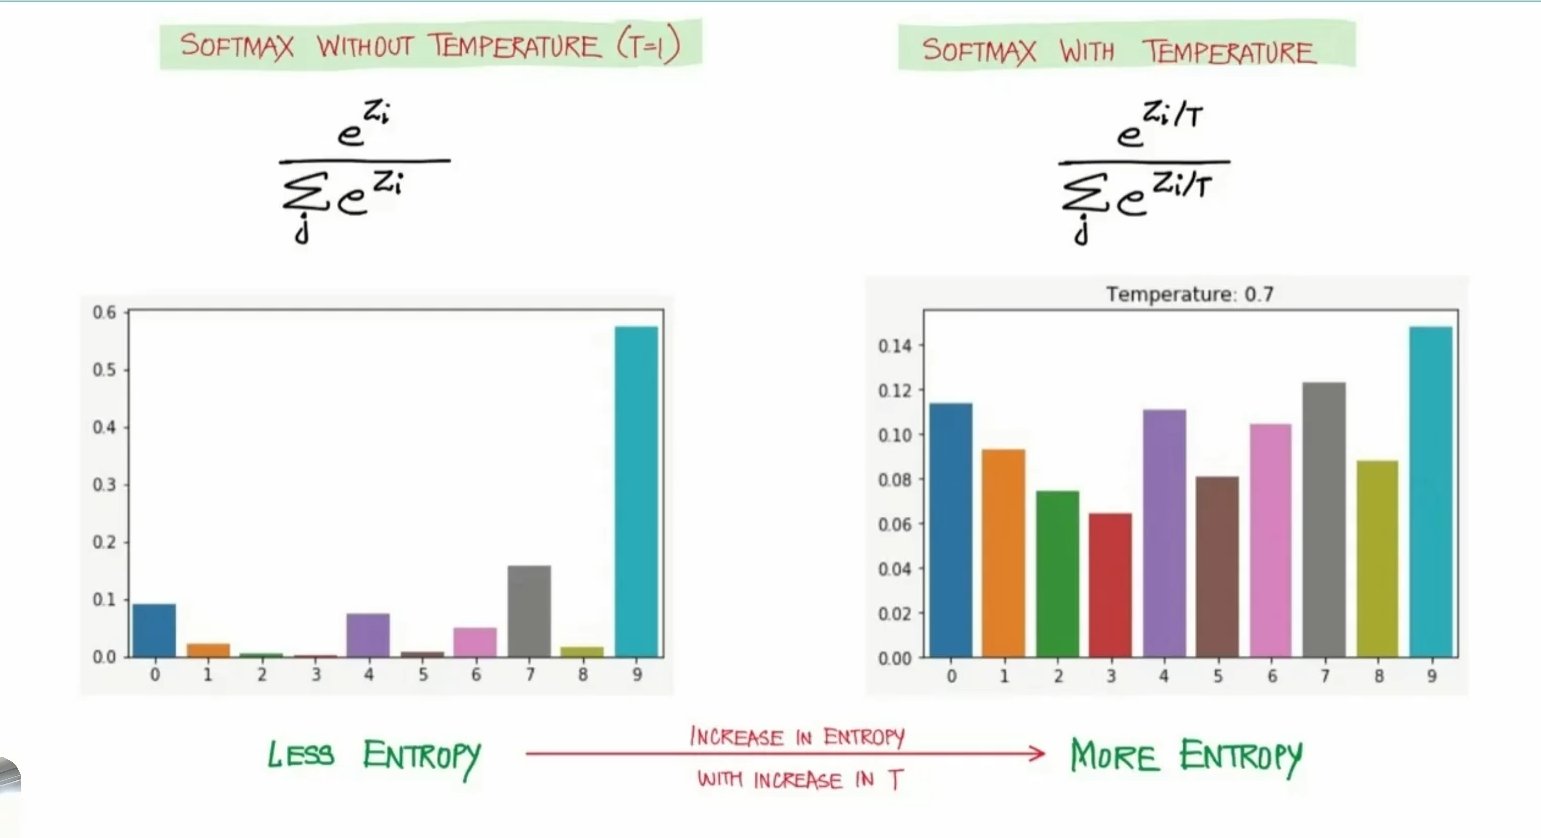

# **STRATEGY-2: TOP-K SAMPLING**

In [23]:
model.to("cpu")
model.eval()

GPT_MODEL(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_fea

In this section, we introduce another concept called top-k sampling, which, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.

In [24]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [25]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [26]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


# **MERGING TEMPERATURE SCALING AND TOP-K SAMPLING**

<div class="alert alert-block alert-info">

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

</div>

In [27]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [28]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you in," she to surprise. It is to! She! by his knees
